In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import *

import json

In [3]:
torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/paperspace/data/Baby_CNN/BCP/Binary')
MASKS_FN = 'GM.csv'
#Train_FN = 'BCP_training.csv'
#META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
train_csv = [t.replace('label', 'T2') for t in masks_csv['ID']]
train_csv = [t.replace('png', 'jpg') for t in train_csv ]

I=pd.DataFrame(train_csv,columns=['ID'])  
I.to_csv(f'{PATH}/BCP_training.csv')
#meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
TRAIN_DN = 'T2_Training'
MASKS_DN = 'GM'
sz = 256
bs = 32
nw = 8

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [9]:
x_names = np.array([Path(TRAIN_DN)/o for o in train_csv])
y_names = np.array([Path(MASKS_DN)/o for o in masks_csv['ID']])

###  Here we try a random 20% training dataset instead of fixed number
### *The code from lesson1-breeds*

In [10]:
n = len(list(open(f'{PATH}/BCP_training.csv'))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [11]:
#val_idxs = list(range(200)) ### here we try a random 20% training dataset instead of fixed number 
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)


Fastai provides an easy and effective way to augment your data. Its data augmentation capabilities are stored within [transform.py] (https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1) in the fastai library.

In [12]:
trn_x.shape,val_x.shape

((745,), (186,))

####  data augmentation parameters experiments 

In [13]:
aug_tfms = [RandomRotate(4,p=0.7, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [14]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [15]:
md.trn_ds.fnames[0]

PosixPath('T2_Training/subject-1-T2_slice_0092.jpg')

In [16]:
md.trn_y

array([PosixPath('GM/subject-1-label_slice_0092.png'), PosixPath('GM/subject-1-label_slice_0093.png'),
       PosixPath('GM/subject-1-label_slice_0095.png'), PosixPath('GM/subject-1-label_slice_0096.png'),
       PosixPath('GM/subject-1-label_slice_0097.png'), PosixPath('GM/subject-1-label_slice_0098.png'),
       PosixPath('GM/subject-1-label_slice_0099.png'), PosixPath('GM/subject-1-label_slice_0100.png'),
       PosixPath('GM/subject-1-label_slice_0101.png'), PosixPath('GM/subject-1-label_slice_0102.png'),
       PosixPath('GM/subject-1-label_slice_0103.png'), PosixPath('GM/subject-1-label_slice_0104.png'),
       PosixPath('GM/subject-1-label_slice_0105.png'), PosixPath('GM/subject-1-label_slice_0106.png'),
       PosixPath('GM/subject-1-label_slice_0107.png'), PosixPath('GM/subject-1-label_slice_0108.png'),
       PosixPath('GM/subject-1-label_slice_0109.png'), PosixPath('GM/subject-1-label_slice_0110.png'),
       PosixPath('GM/subject-1-label_slice_0111.png'), PosixPath('GM/subj

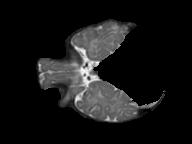

In [17]:
fn = f'{PATH}/{md.trn_ds.fnames[90]}'; fn
img = PIL.Image.open(fn); img

In [18]:
x,y = next(iter(md.trn_dl))

In [19]:
x.shape,y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

## Simple upsample

## simple use

In [20]:
f = resnet34
cut,lr_cut = model_meta[f]

In [21]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [22]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [23]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [24]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [25]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

####  Since our image is very different from the fastai course, we need to change the learning rate across layers.  
####  we should let the first layers learning rate faster to make it learn quicker. 

## U-net (ish)

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [28]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
# 

In [30]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [31]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [32]:
# m_base = get_base()
# m = to_gpu(DynamicUnet(m_base))
# models = UnetModel(m)

In [32]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [34]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 64, 

In [35]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 128, 128]),
 torch.Size([3, 64, 64, 64]),
 torch.Size([3, 128, 32, 32]),
 torch.Size([3, 256, 16, 16])]

In [36]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      2.111747   2.48719658951e+20 0.148623   0.258208  



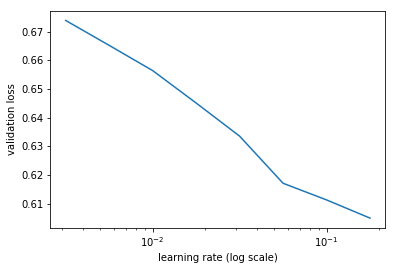

In [37]:
learn.lr_find()
learn.sched.plot()

In [40]:
lr=1e-1
wd=1e-2

#lrs = np.array([lr/100,lr/10,lr])/2

### Use the new way of doing things with restart (recommended):

In [41]:
learn.fit(lr, n_cycle=3, wds=0.025, use_wd_sched=True, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

 46%|████▌     | 11/24 [00:06<00:07,  1.63it/s, loss=0.169]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.160894   0.162942   0.903342   0.679272  
    1      0.145949   0.139412   0.925683   0.773388       
    2      0.14297    0.145132   0.930496   0.784893       
    3      0.139731   0.147752   0.913915   0.734772       
    4      0.137102   0.135446   0.926318   0.775408       
    5      0.133099   0.133121   0.932969   0.792779       
    6      0.134337   0.154679   0.908079   0.709263       
    7      0.135202   0.138581   0.925613   0.768482       
    8      0.135627   0.13983    0.932836   0.791125       
    9      0.134654   0.151255   0.931862   0.787984       
    10     0.132738   0.133023   0.931225   0.787966       
    11     0.12973    0.133446   0.936886   0.801977       
    12     0.126358   0.128463   0.935661   0.800169       
    13     0.123839   0.128066   0.935112   0.798876       



[array([ 0.12807]), 0.93511240969422038, 0.79887607424912166]

#### Differential learning rate and weight regularization factor (wds):

In [42]:

learn.unfreeze()
learn.fit(lrs=[lr/100, lr/10,lr], n_cycle=10, wds=[wd/100, wd/10, wd], use_wd_sched=True, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2046), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.240003   0.165913   0.9105     0.715237  
    1      0.181138   0.144953   0.923903   0.768438       
    2      0.161168   0.140793   0.919246   0.754415       
    3      0.146751   0.146605   0.908342   0.703491       
    4      0.137532   0.13068    0.936508   0.801443       
    5      0.130644   0.129005   0.934446   0.796468       
    6      0.130579   0.142489   0.924633   0.755244       
    7      0.128338   0.132293   0.9261     0.770022       
    8      0.124656   0.126488   0.932942   0.792184       
    9      0.12239    0.123804   0.940577   0.813228       
    10     0.118475   0.121136   0.941347   0.815833       
    11     0.115066   0.119378   0.939796   0.812349       
    12     0.112803   0.118697   0.941005   0.815691       
    13     0.111563   0.118767   0.942643   0.819337       
    14     0.113282   0.123763   0.935266   0.798364       
    15     0.113955   0.121188   0.941011   0

   267     0.064466   0.099612   0.957302   0.859793        
   268     0.064475   0.106568   0.951963   0.84183         
   269     0.06469    0.094      0.958776   0.866087        
   270     0.06393    0.090807   0.961892   0.874858        
   271     0.062759   0.090882   0.961592   0.874332        
   272     0.062594   0.089924   0.962963   0.878309        
   273     0.063244   0.093863   0.960173   0.86965         
   274     0.063037   0.094302   0.963498   0.879357        
   275     0.062134   0.090453   0.962593   0.877352        
   276     0.061359   0.093145   0.961982   0.875074        
   277     0.060608   0.090865   0.962749   0.877668        
   278     0.059955   0.090908   0.961448   0.874187        
   279     0.0595     0.08904    0.961178   0.874027        
   280     0.059721   0.088476   0.962141   0.876643        
   281     0.059432   0.092409   0.963174   0.878958        
   282     0.05956    0.089509   0.963219   0.878928        
   283     0.059352   0.

   535     0.115571   0.1233     0.941289   0.815252       
   536     0.114419   0.119668   0.940449   0.81522        
   537     0.113179   0.119568   0.94081    0.816323       
   538     0.111778   0.120459   0.937489   0.806414       
   539     0.110669   0.119222   0.937398   0.80793        
   540     0.109342   0.117851   0.943405   0.822204       
   541     0.107922   0.116314   0.943665   0.823634       
   542     0.106905   0.118734   0.938575   0.80852        
   543     0.105772   0.116468   0.939151   0.813588       
   544     0.104628   0.113974   0.944429   0.826375       
   545     0.104016   0.114149   0.946272   0.829616       
   546     0.102823   0.113414   0.946028   0.829574       
   547     0.102356   0.113367   0.947831   0.833172       
   548     0.10125    0.111806   0.945853   0.829736       
   549     0.100392   0.113964   0.946331   0.829798       
   550     0.100004   0.11201    0.947393   0.833324        
   551     0.099185   0.112589   0.9433

   803     0.046763   0.092913   0.966841   0.890215        
   804     0.047011   0.090152   0.966537   0.889493        
   805     0.046793   0.092839   0.966737   0.889894        
   806     0.046105   0.093957   0.966259   0.888504        
   807     0.046039   0.091968   0.966199   0.888284        
   808     0.045857   0.094284   0.967388   0.891989        
   809     0.046909   0.098292   0.967074   0.890104        
   810     0.046524   0.093356   0.967219   0.891226        
   811     0.045564   0.093727   0.967438   0.891796        
   812     0.045613   0.089606   0.967013   0.891007        
   813     0.045819   0.094273   0.966869   0.890364        
   814     0.045249   0.09129    0.967206   0.891364        
   815     0.044928   0.099518   0.96667    0.889377        
   816     0.044956   0.093457   0.965738   0.886886        
   817     0.044849   0.092538   0.966852   0.890314        
   818     0.045139   0.100154   0.96759    0.892154        
   819     0.045311   0.

   1071    0.073885   0.094862   0.954888   0.856262        
   1072    0.073533   0.092713   0.956967   0.862026        
   1073    0.073223   0.092552   0.959073   0.866683        
   1074    0.073206   0.091742   0.958347   0.865646        
   1075    0.073387   0.092606   0.958889   0.866284        
   1076    0.072898   0.092063   0.957233   0.862804        
   1077    0.072349   0.090864   0.958239   0.865839        
   1078    0.071882   0.091977   0.960006   0.868978        
   1079    0.071244   0.091201   0.959006   0.867342        
   1080    0.071542   0.091265   0.95889    0.867047        
   1081    0.070943   0.093795   0.955706   0.858398        
   1082    0.069673   0.092199   0.958232   0.86508         
   1083    0.069369   0.091293   0.959961   0.86932         
   1084    0.069253   0.090163   0.959125   0.867983        
   1085    0.069026   0.094049   0.955171   0.856869        
   1086    0.068756   0.09094    0.958671   0.866776        
   1087    0.068651   0.

   1339    0.043652   0.098379   0.967837   0.892947        
   1340    0.043503   0.094409   0.967037   0.890593        
   1341    0.043204   0.104214   0.968009   0.893715        
   1342    0.04318    0.097125   0.967872   0.893098        
   1343    0.043598   0.096325   0.967398   0.891691        
   1344    0.04355    0.099766   0.967762   0.89264         
   1345    0.043425   0.094438   0.966693   0.889672        
   1346    0.043691   0.096635   0.966916   0.889944        
   1347    0.043402   0.098167   0.967386   0.891601        
   1348    0.043446   0.100759   0.967344   0.891231        
   1349    0.04328    0.093862   0.967777   0.892846        
   1350    0.043168   0.094379   0.967514   0.892019        
   1351    0.043087   0.099348   0.966291   0.887731        
   1352    0.043367   0.095266   0.966525   0.888844        
   1353    0.042908   0.098425   0.967692   0.89255         
   1354    0.042942   0.094452   0.966487   0.888682        
   1355    0.042464   0.

   1607    0.033973   0.118803   0.968974   0.896406        
   1608    0.033971   0.121466   0.968251   0.893412        
   1609    0.033859   0.119902   0.96855    0.894551        
   1610    0.033704   0.118876   0.968791   0.895686        
   1611    0.033403   0.123386   0.968505   0.894349        
   1612    0.033679   0.119712   0.969014   0.896408        
   1613    0.033395   0.128045   0.968709   0.895196        
   1614    0.033343   0.113655   0.967909   0.892465        
   1615    0.033321   0.126323   0.968745   0.89537         
   1616    0.033446   0.123424   0.968881   0.895995        
   1617    0.033705   0.120306   0.968674   0.895344        
   1618    0.033311   0.120696   0.968719   0.895357        
   1619    0.032829   0.12234    0.968637   0.895014        
   1620    0.033188   0.119288   0.968323   0.893733        
   1621    0.032868   0.120296   0.968696   0.895341        
   1622    0.033013   0.11881    0.968497   0.89463         
   1623    0.032986   0.

   1875    0.026058   0.180833   0.969312   0.896972        
   1876    0.025954   0.178991   0.969372   0.897319        
   1877    0.026291   0.176824   0.969288   0.896965        
   1878    0.026416   0.177816   0.969158   0.89627         
   1879    0.026346   0.178778   0.969204   0.896501        
   1880    0.026776   0.178194   0.969225   0.896598        
   1881    0.026574   0.178192   0.96922    0.896494        
   1882    0.026505   0.176779   0.969196   0.896551        
   1883    0.026203   0.177816   0.969261   0.897147        
   1884    0.026181   0.176012   0.969171   0.896485        
   1885    0.026149   0.176735   0.969291   0.896935        
   1886    0.026625   0.181494   0.969218   0.896844        
   1887    0.026607   0.178184   0.969273   0.89693         
   1888    0.027125   0.179864   0.969268   0.896813        
   1889    0.026485   0.18329    0.969256   0.896695        
   1890    0.025905   0.182874   0.969318   0.897108        
   1891    0.025548   0.

[array([ 0.20249]), 0.96933959312336415, 0.89701453098325445]

In [43]:
learn.save('128urn-c0')

In [33]:
learn.load('128urn-c0')
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

0.9125506072874494
0.9068749260442551
0.8685754435271386
0.8605481065724284
0.889815366289458
0.9127005170356622
0.9194027962295186
0.917075971167953
0.9061374935710612
0.8906918294457428
0.8471426232192566
0.8170344560588463
0.8624116691229263
0.9108482177375705
0.901771862496938
0.8631138044737545


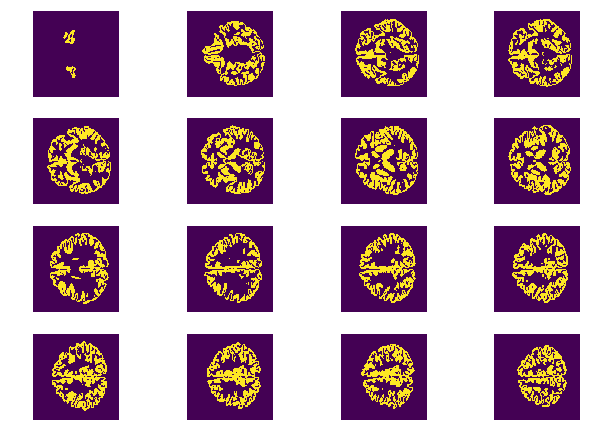

In [34]:
fig,  axes  =  plt.subplots(4, 4, figsize=(9, 6))

for i,ax in enumerate(axes.flat):

    pred=py[i]>0
    targs=y[i]
    show_img(pred, ax=ax)
    plt.tight_layout(pad=0.1)
#     show_img(pred);
#     show_img(targs);
#     plt.hist(targs)
#     plt.show()

    print(2. * (pred*targs).sum() / (pred+targs).sum())

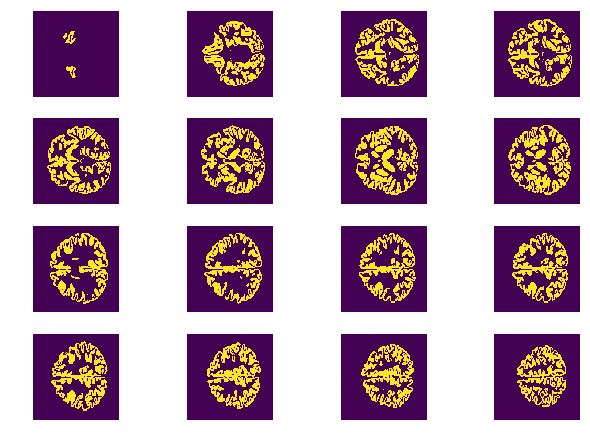

In [35]:
fig,  axes  =  plt.subplots(4, 4, figsize=(9, 6))

for i,ax in enumerate(axes.flat):

    pred=py[i]>0
    targs=y[i]
    show_img(targs, ax=ax)
    plt.tight_layout(pad=0.1)

In [ ]:
m.close()